In [ ]:
# importing libraries
import numpy as np
import math
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
try:
    from transformers import AutoTokenizer,AutoModelForQuestionAnswering
except:
    %pip install transformers
    from transformers import AutoTokenizer,AutoModelForQuestionAnswering
import typing as ty
try:
    from captum.attr import LayerConductance, LayerIntegratedGradients, IntegratedGradients
    from captum.attr import visualization as viz
except:
    %pip install captum
    from captum.attr import LayerConductance, LayerIntegratedGradients, IntegratedGradients
    from captum.attr import visualization as viz


     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 6.6 MB 36.0 MB/s 
     |████████████████████████████████| 596 kB 34.8 MB/s 
     |████████████████████████████████| 880 kB 44.6 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=bcb80e9c542ec0dad71bcebfca8022b525ef7240012f53f1b1949815f18d003e
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.4 MB 5.4 MB/s 


In [ ]:
from transformers import AutoModel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# setting sdevice to gpu if it is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

Tesla K80


In [ ]:
# using a fine-tuned tokenizer
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/dl_project/Epoch_3")
# using a fine-tuned bert model
# using a fine-tuned tokenizer
model = AutoModelForQuestionAnswering.from_pretrained("/content/drive/MyDrive/dl_project/Epoch_3")
# sending model to device (gpu if available)
model.to(device)
# switching from training mode to testing
model.eval()
model.zero_grad()

In [ ]:
def predict(inputs : torch.tensor, token_type_ids : torch.tensor = None, \
            position_ids : torch.tensor = None, attention_mask : torch.tensor = None, output_hidden_states = False)\
            -> ty.Tuple[torch.tensor, torch.tensor]:
    """
    Returns
    -------
    start_logits, end_logits

    start_logits and end_logits are used to determine the span of the answer
    given in the text or question.
    """
    if(inputs is not None):
        inputs = inputs.to(torch.long)
    if(token_type_ids is not None):
        token_type_ids = token_type_ids.to(torch.long)
    if(position_ids is not None):
        position_ids = position_ids = position_ids.to(torch.long)
    if(attention_mask is not None):
        attention_mask = attention_mask - attention_mask.to(torch.long)
    output = model(inputs, token_type_ids=token_type_ids,position_ids=position_ids, attention_mask=attention_mask,output_hidden_states = output_hidden_states)
    return output.start_logits, output.end_logits

In [ ]:
sep = tokenizer.sep_token_id 
cls = tokenizer.cls_token_id

In [ ]:
# def bert_forward_func(inputs)

def construct_inputs(question : str, context : str, cls : torch.tensor, sep : torch.tensor) -> ty.Tuple[torch.tensor, int]:
    """
    Returns
    -------
    input_ids

    input_ids are the sequence of tokens generated after appending 
    [cls] + question + [sep] + context + [sep]

    Here, [sep] is the separator token which is used to mark the end of text,
    while [cls] token is used to begin the sequence of tokens.
    """
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(context, add_special_tokens=False)
    input_ids = [cls] + question_ids + [sep] + text_ids + [sep]
    input_ids = torch.tensor([input_ids],device=device)
    sep_ind = len(question_ids)
    return input_ids, sep_ind

def construct_attention_mask(input_ids : torch.tensor) -> torch.tensor:
    """
    Returns
    -------
    attention mask

    Attention mask is a tensor with all ones representing where to pay attention.
    We are not zero padding input ids, so attention mask with all ones works in
    our case
    """
    attention_mask = torch.ones_like(input_ids)
    return attention_mask

def construct_token_type_ids(input_ids : torch.tensor, sep_ind : int = 0):
    """
    Returns
    -------
    token type ids

    token type ids represent the class of the token, here it is 0 for the tokens
    belonging to question, while 1 for separating token and context tokens
    """
    len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(len)]], device=device)
    return token_type_ids


def construct_position_ids(input_ids : torch.tensor) -> torch.tensor:
    """
    Returns
    -------
    position ids

    position ids are the index(position) of each input id token
    """
    len = input_ids.size(1) 
    position_ids = torch.arange(len, dtype=torch.long, device=device)
    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids

def decipher_output_token(input_ids : torch.tensor, start: torch.tensor, end : torch.tensor) -> str:
    """
    Returns
    -------
    The answer to the question from text
    """
    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)
    start_token = torch.argmax(start)
    end_token = torch.argmax(end)
    output = ' '.join(all_tokens[start_token:end_token+1])
    return output


# Visualization

In [ ]:
def bert_forward_func(inputs : torch.tensor, token_type_ids : torch.tensor = None, \
            position_ids : torch.tensor = None, attention_mask : torch.tensor = None,\
            pos : int = 0) -> torch.tensor:
    """
    As there are two outputs from our model (start and end), In order to
    visulaize them we keep a position index to access them separately
    """
    output = predict(inputs,token_type_ids,position_ids,attention_mask)
    output = output[pos]
    return output.max(1).values

def construct_baselines(input_ids : torch.tensor, sep_ind: int):
    """
    Returns
    -------
    A tensor with same size as input id, but zero everywhere apart from
    cls, sep.-

    Baselines are the starting index from which the integral gradients are
    computed
    """
    baselines = torch.zeros_like(input_ids)
    baselines[0][0] = cls
    baselines[0][-1] = sep
    baselines[0][sep_ind] = sep
    return baselines

In [ ]:
def summarize_attributions(attributions : torch.tensor) -> torch.tensor:
    """
    Returns
    -------
    Summarized attributions on all embeddings
    """
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = (attributions) / torch.norm(attributions)
    return attributions

In [ ]:
def normalised_attribution_scores(attributions : torch.tensor):
    """
    Prints
    ------
    Normalised attribution scores
    """
    norm_attributions = torch.norm(attributions,dim=-1)
    return norm_attributions

In [ ]:
def visualize_attributions(question : str, context : str,ground_truth : str, forward_fun : ty.Callable, layer):
    """
    Prints highlighted text representing the importance of word in the input
    """
    ig = LayerIntegratedGradients(forward_fun,layer)

    input_ids, sep_ind = construct_inputs(question,context,cls,sep)
    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)
    attention_mask = construct_attention_mask(input_ids)
    token_type_ids = construct_token_type_ids(input_ids,sep_ind)
    position_ids = construct_position_ids(input_ids)
    baselines = construct_baselines(input_ids,sep_ind)

    ground_truth_tokens = tokenizer.encode(ground_truth, add_special_tokens=False)
    ground_truth_end_ind = indices.index(ground_truth_tokens[-1])
    ground_truth_start_ind = ground_truth_end_ind - len(ground_truth_tokens) + 1

    start,end = predict(input_ids,token_type_ids,position_ids,attention_mask)
    
    print('Predicted Answer : ', decipher_output_token(input_ids,start,end),'\n\n')
    attributions_start, delta_start = ig.attribute(inputs=input_ids,
                                baselines=baselines,
                                additional_forward_args=(token_type_ids, position_ids, attention_mask, 0),
                                return_convergence_delta=True)
    
    attributions_end, delta_end = ig.attribute(inputs=input_ids, 
                                    baselines=baselines,
                                    additional_forward_args=(token_type_ids, position_ids, attention_mask, 1),
                                    return_convergence_delta=True)
    
    
    attributions_start_normalised = summarize_attributions(attributions_start)
    attributions_end_normalised = summarize_attributions(attributions_end)


    start_position_vis = viz.VisualizationDataRecord(
                            word_attributions=attributions_start_normalised,
                            pred_prob=torch.max(torch.softmax(start[0], dim=0)),
                            pred_class=torch.argmax(start),
                            true_class=str(ground_truth_start_ind),
                            attr_class=torch.argmax(start),
                            attr_score=attributions_start_normalised.sum(),
                            raw_input_ids=all_tokens,
                            convergence_score=delta_start)

    end_position_vis = viz.VisualizationDataRecord(
                            word_attributions=attributions_end_normalised,
                            pred_prob=torch.max(torch.softmax(end[0], dim=0)),
                            pred_class=torch.argmax(end),
                            true_class=str(ground_truth_end_ind),
                            attr_class=torch.argmax(end),                        
                            attr_score=attributions_end_normalised.sum(),       
                            raw_input_ids=all_tokens,
                            convergence_score=delta_end)

    print('\033[1m', 'Visualizations For Start Position', '\033[0m')
    viz.visualize_text([start_position_vis])

    print('\033[1m', 'Visualizations For End Position', '\033[0m')
    viz.visualize_text([end_position_vis])
    return 

In [ ]:
def attribution_heatmaps(question : str, context : str,ground_truth : str, forward_fun : ty.Callable):
    """
    Prints highlighted text representing the importance of word in the input
    """

    attributions_start_normalised=[]
    attributions_end_normalised=[]


    for i in range(12):
      ig = LayerIntegratedGradients(forward_fun,model.bert.encoder.layer[i])

      input_ids, sep_ind = construct_inputs(question,context,cls,sep)
      indices = input_ids[0].detach().tolist()
      all_tokens = tokenizer.convert_ids_to_tokens(indices)
      attention_mask = construct_attention_mask(input_ids)
      token_type_ids = construct_token_type_ids(input_ids,sep_ind)
      position_ids = construct_position_ids(input_ids)
      x = position_ids.shape[1]
      baselines = construct_baselines(input_ids,sep_ind)

      ground_truth_tokens = tokenizer.encode(ground_truth, add_special_tokens=False)
      ground_truth_end_ind = indices.index(ground_truth_tokens[-1])
      ground_truth_start_ind = ground_truth_end_ind - len(ground_truth_tokens) + 1

      start,end = predict(input_ids,token_type_ids,position_ids,attention_mask)
      
      
      attributions_start, delta_start = ig.attribute(inputs=input_ids,
                                  baselines=baselines,
                                  additional_forward_args=(token_type_ids, position_ids, attention_mask, 0),
                                  return_convergence_delta=True)
      
      attributions_end, delta_end = ig.attribute(inputs=input_ids, 
                                      baselines=baselines,
                                      additional_forward_args=(token_type_ids, position_ids, attention_mask, 1),
                                      return_convergence_delta=True)
      
      
      attributions_start_normalised.append(summarize_attributions(attributions_start[0]))
      attributions_end_normalised.append(summarize_attributions(attributions_end[0]))

    print('Predicted Answer : ', decipher_output_token(input_ids,start,end),'\n\n')

    attributions_start_normalised=torch.stack(attributions_start_normalised)
    attributions_end_normalised=torch.stack(attributions_end_normalised)
    print('Heatmap of attributions for start token prediction')

    fig, ax=plt.subplots(figsize=(x,x/3))
    xticklabels=all_tokens
    yticklabels=list(range(1,13))
    ax = sns.heatmap(attributions_start_normalised.cpu().detach().numpy(), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2) #, annot=True
    plt.xlabel('Tokens')
    plt.ylabel('Layers')

    plt.show()
    
    print('Heatmap of attributions for end token prediction')
    fig, ax=plt.subplots(figsize=(x,x/3))
    xticklabels=all_tokens
    yticklabels=list(range(1,13))
    ax = sns.heatmap(attributions_end_normalised.cpu().detach().numpy(), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2) #, annot=True
    plt.xlabel('Tokens')
    plt.ylabel('Layers')

    plt.show()    

In [ ]:
context = 'Following Russian invasion of Ukraine, more than a dozen countries have sanctioned Russia. One of them is USA'
question = 'Why did countries sanction Russia?'
ground_truth = 'russian invasion of ukraine'
for i in range(12):
    visualize_attributions(question,context,ground_truth,bert_forward_func,model.bert.encoder.layer[i])

Predicted Answer :  russian invasion of ukraine 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  russian invasion of ukraine 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  russian invasion of ukraine 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  russian invasion of ukraine 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  russian invasion of ukraine 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  russian invasion of ukraine 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  russian invasion of ukraine 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  russian invasion of ukraine 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  russian invasion of ukraine 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  russian invasion of ukraine 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  russian invasion of ukraine 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  russian invasion of ukraine 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  russian invasion of ukraine 


Heatmap of attributions for start token prediction


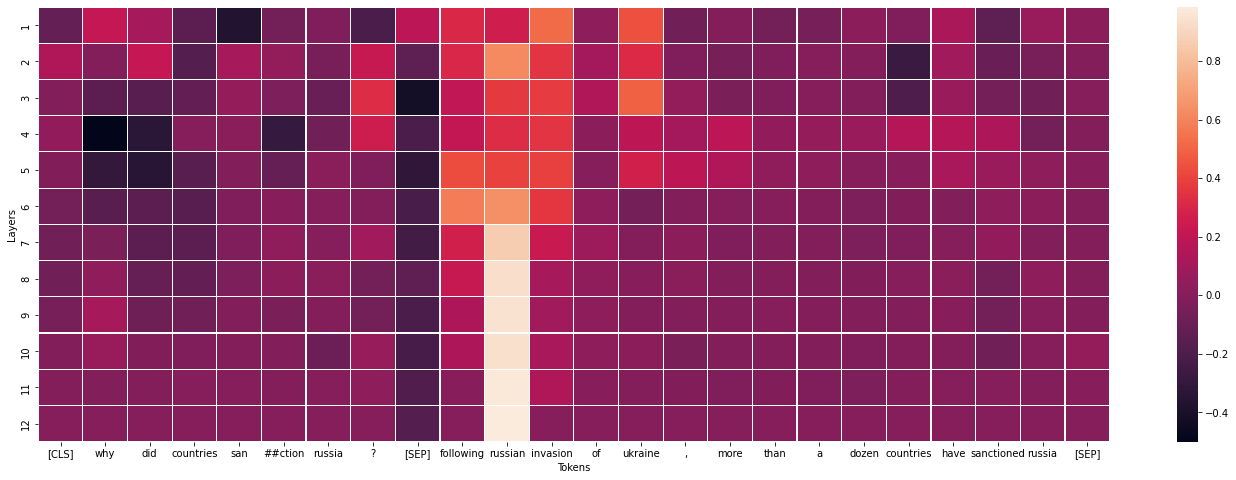

Heatmap of attributions for end token prediction


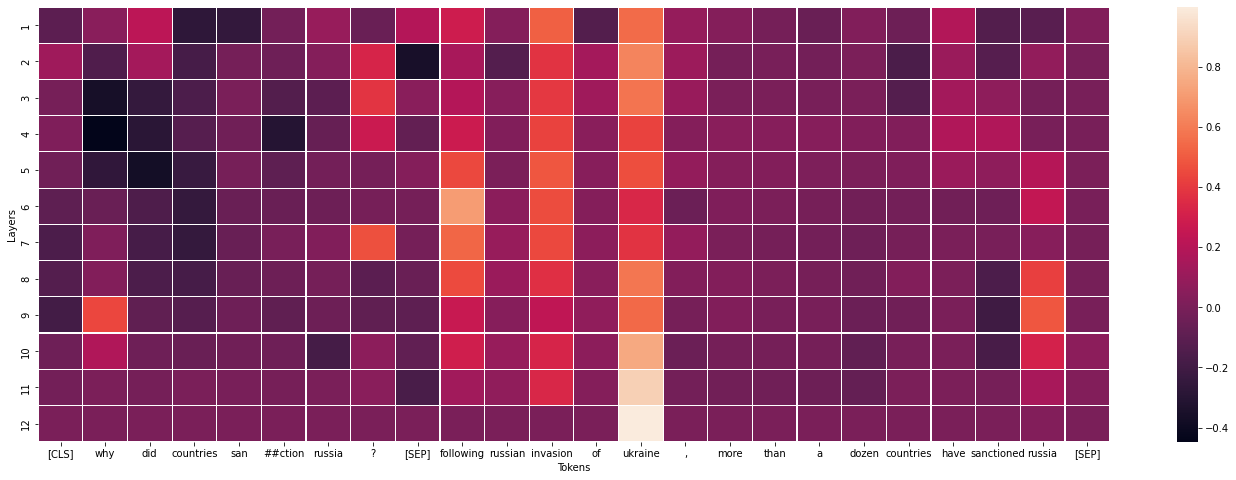

In [ ]:
context = 'Following Russian invasion of Ukraine, more than a dozen countries have sanctioned Russia'
question = 'Why did countries sanction Russia?'
ground_truth = 'russian invasion of ukraine'
attribution_heatmaps(question, context,ground_truth, bert_forward_func)

In [ ]:
context = 'The Panthers finished the regular season with a 15–1 record, and quarterback Cam Newton was named the NFL Most Valuable Player (MVP). They defeated the Arizona Cardinals 49–15 in the NFC Championship Game and advanced to their second Super Bowl appearance since the franchise was founded in 1995. The Broncos finished the regular season with a 12–4 record, and denied the New England Patriots a chance to defend their title from Super Bowl XLIX by defeating them 20–18 in the AFC Championship Game. They joined the Patriots, Dallas Cowboys, and Pittsburgh Steelers as one of four teams that have made eight appearances in the Super Bowl. The 2020 regular season win/loss ratio for the Michigan Vikings was 656.'
question = 'How many appearances have the Broncos made in the super bowl?'
ground_truth = 'eight'
for i in range(12):
    visualize_attributions(question,context,ground_truth,bert_forward_func,model.bert.encoder.layer[i])

Predicted Answer :  eight 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  eight 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  eight 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  eight 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  eight 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  eight 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  eight 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  eight 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  eight 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  eight 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  eight 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  eight 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  eight 


Heatmap of attributions for start token prediction


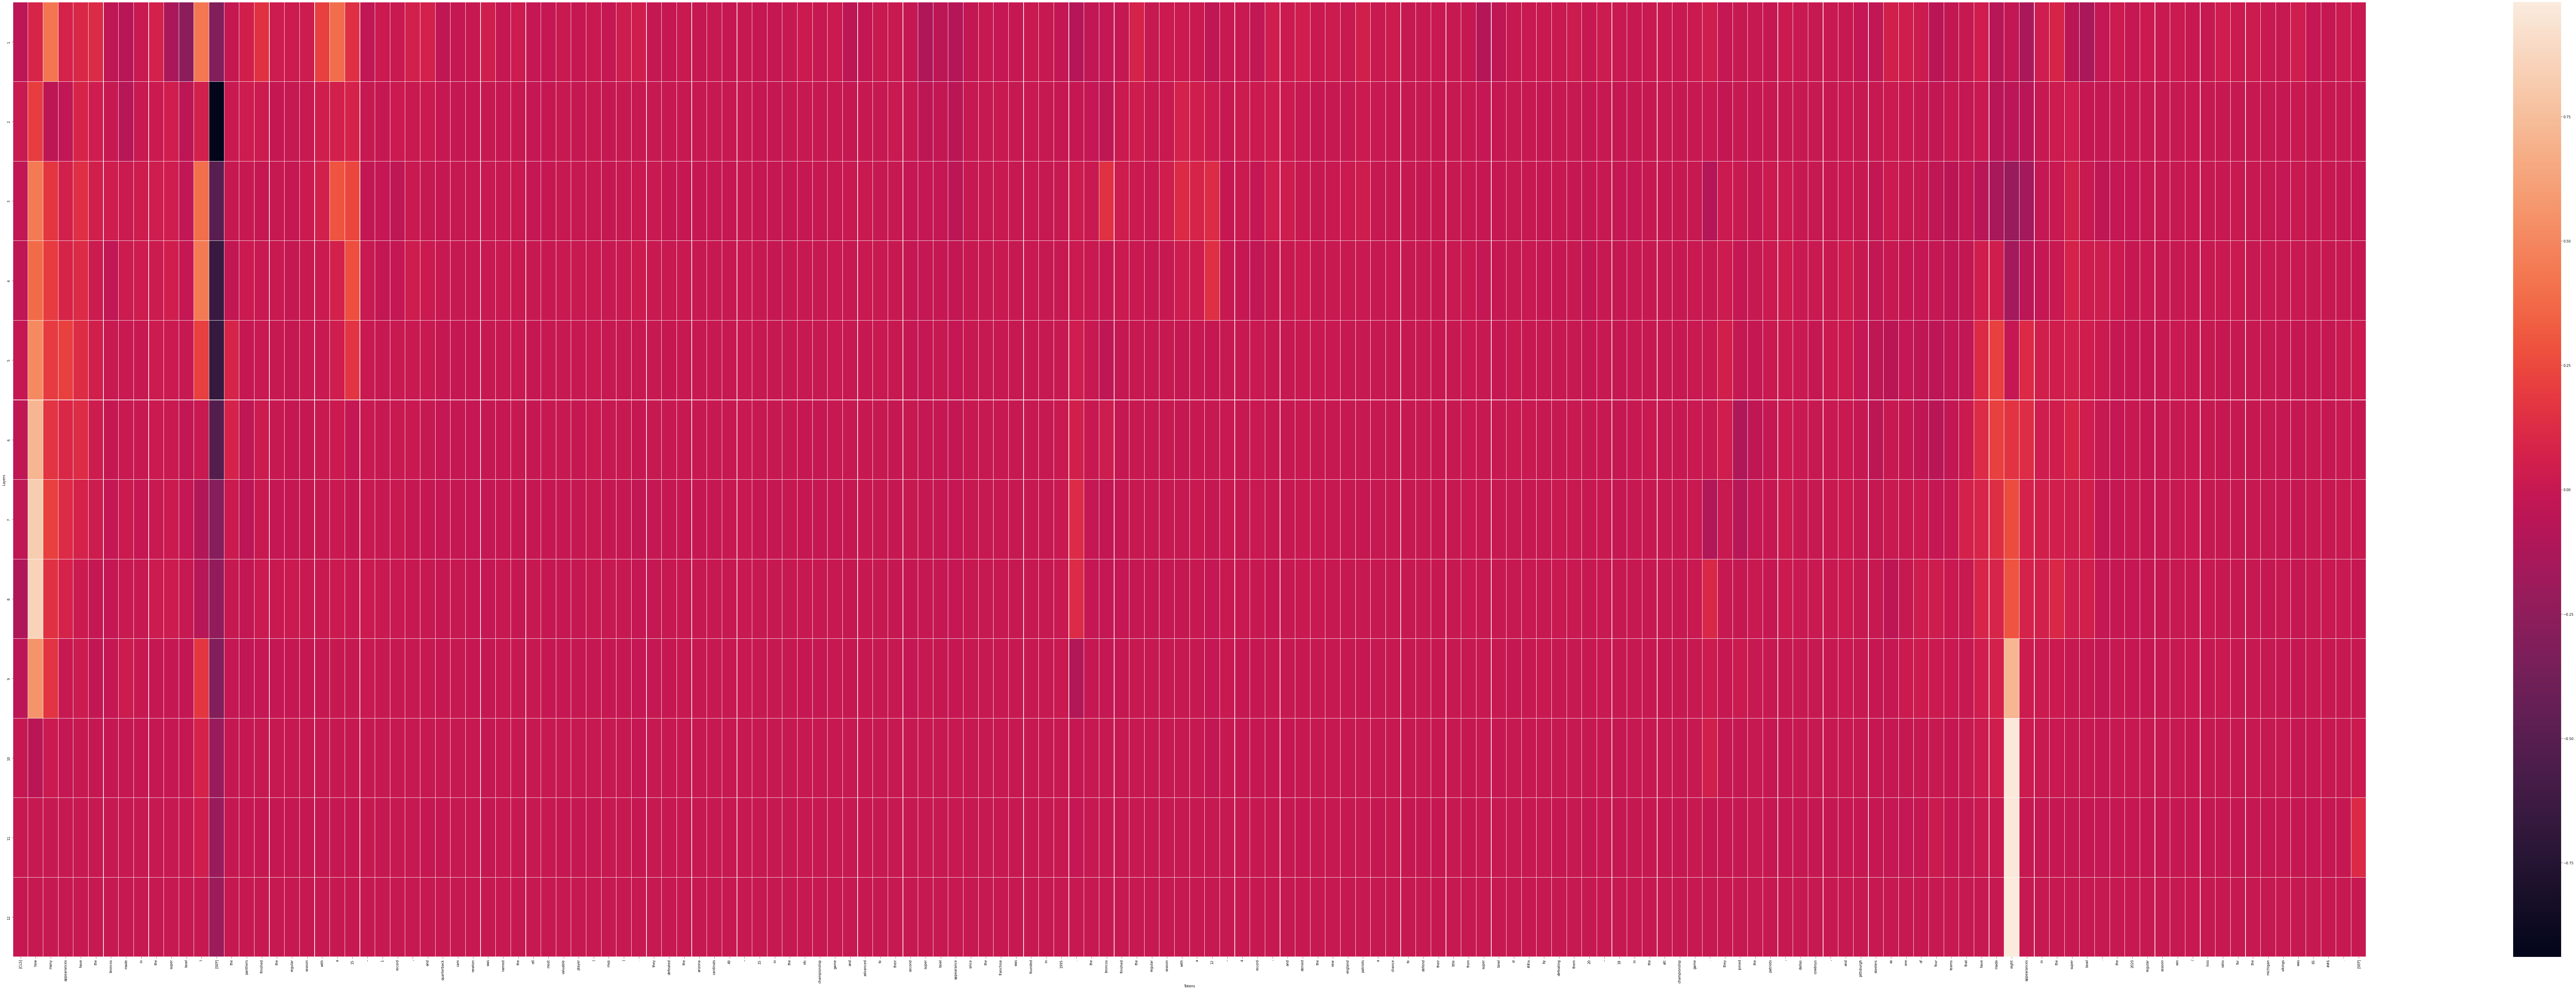

Heatmap of attributions for end token prediction


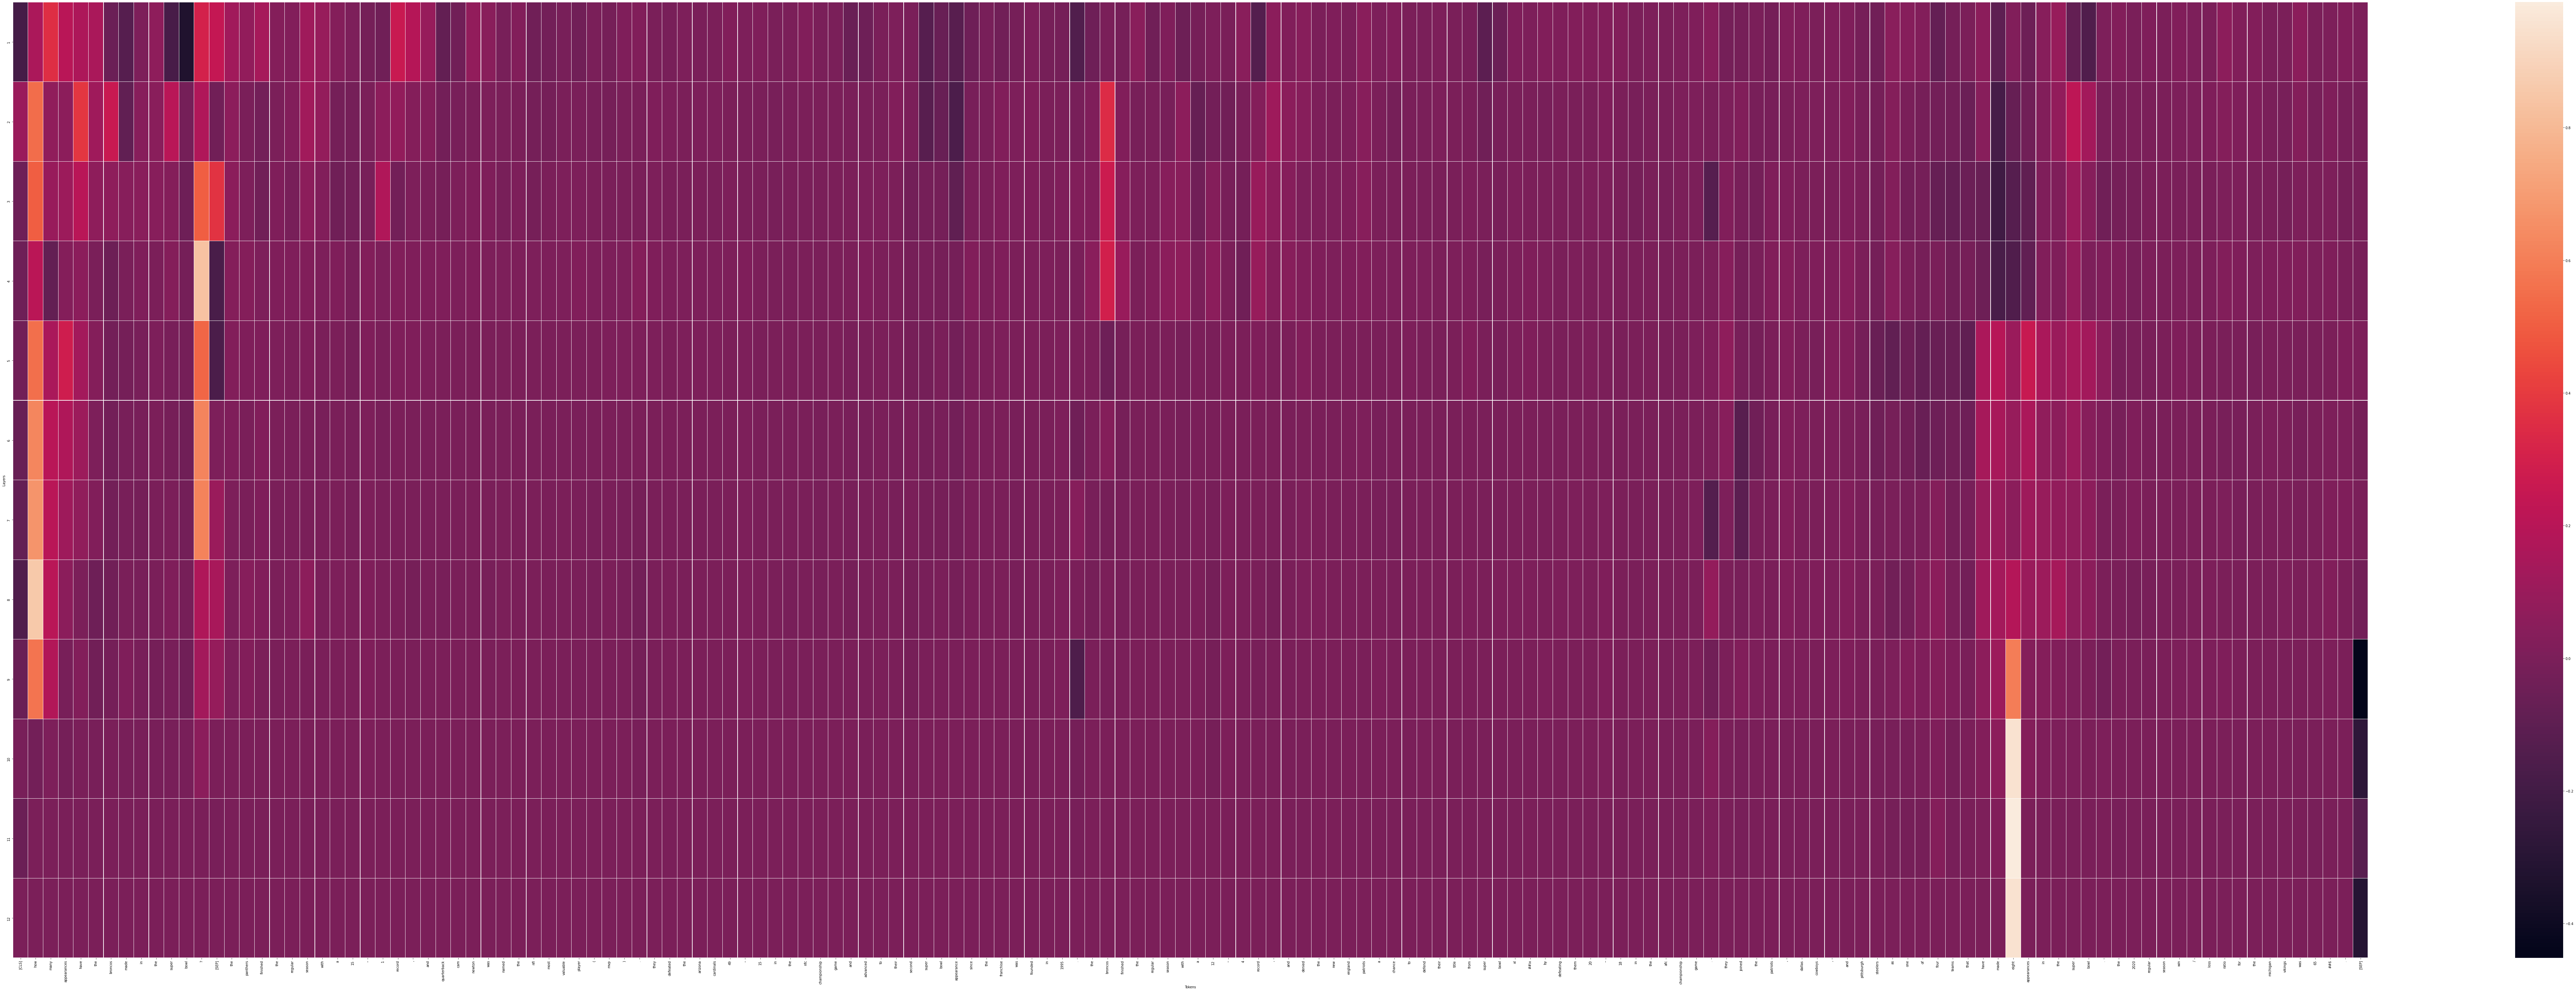

In [ ]:
context = 'The Panthers finished the regular season with a 15–1 record, and quarterback Cam Newton was named the NFL Most Valuable Player (MVP). They defeated the Arizona Cardinals 49–15 in the NFC Championship Game and advanced to their second Super Bowl appearance since the franchise was founded in 1995. The Broncos finished the regular season with a 12–4 record, and denied the New England Patriots a chance to defend their title from Super Bowl XLIX by defeating them 20–18 in the AFC Championship Game. They joined the Patriots, Dallas Cowboys, and Pittsburgh Steelers as one of four teams that have made eight appearances in the Super Bowl. The 2020 regular season win/loss ratio for the Michigan Vikings was 656.'
question = 'How many appearances have the Broncos made in the super bowl?'
ground_truth = 'eight'
attribution_heatmaps(question, context,ground_truth, bert_forward_func)

In [ ]:
context = 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50. Champ Bowl 40 took place in the venue of Chicago.'
question = 'What venue did Super Bowl 50 take place in?'
ground_truth = 'Levi\'s Stadium'
for i in range(12):
    visualize_attributions(question,context,ground_truth,bert_forward_func,model.bert.encoder.layer[i])

Predicted Answer :  chicago 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  chicago 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  chicago 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  chicago 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  chicago 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  chicago 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  chicago 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  chicago 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  chicago 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  chicago 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  chicago 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  chicago 


 Visualizations For Start Position 


 Visualizations For End Position 


Predicted Answer :  chicago 


Heatmap of attributions for start token prediction


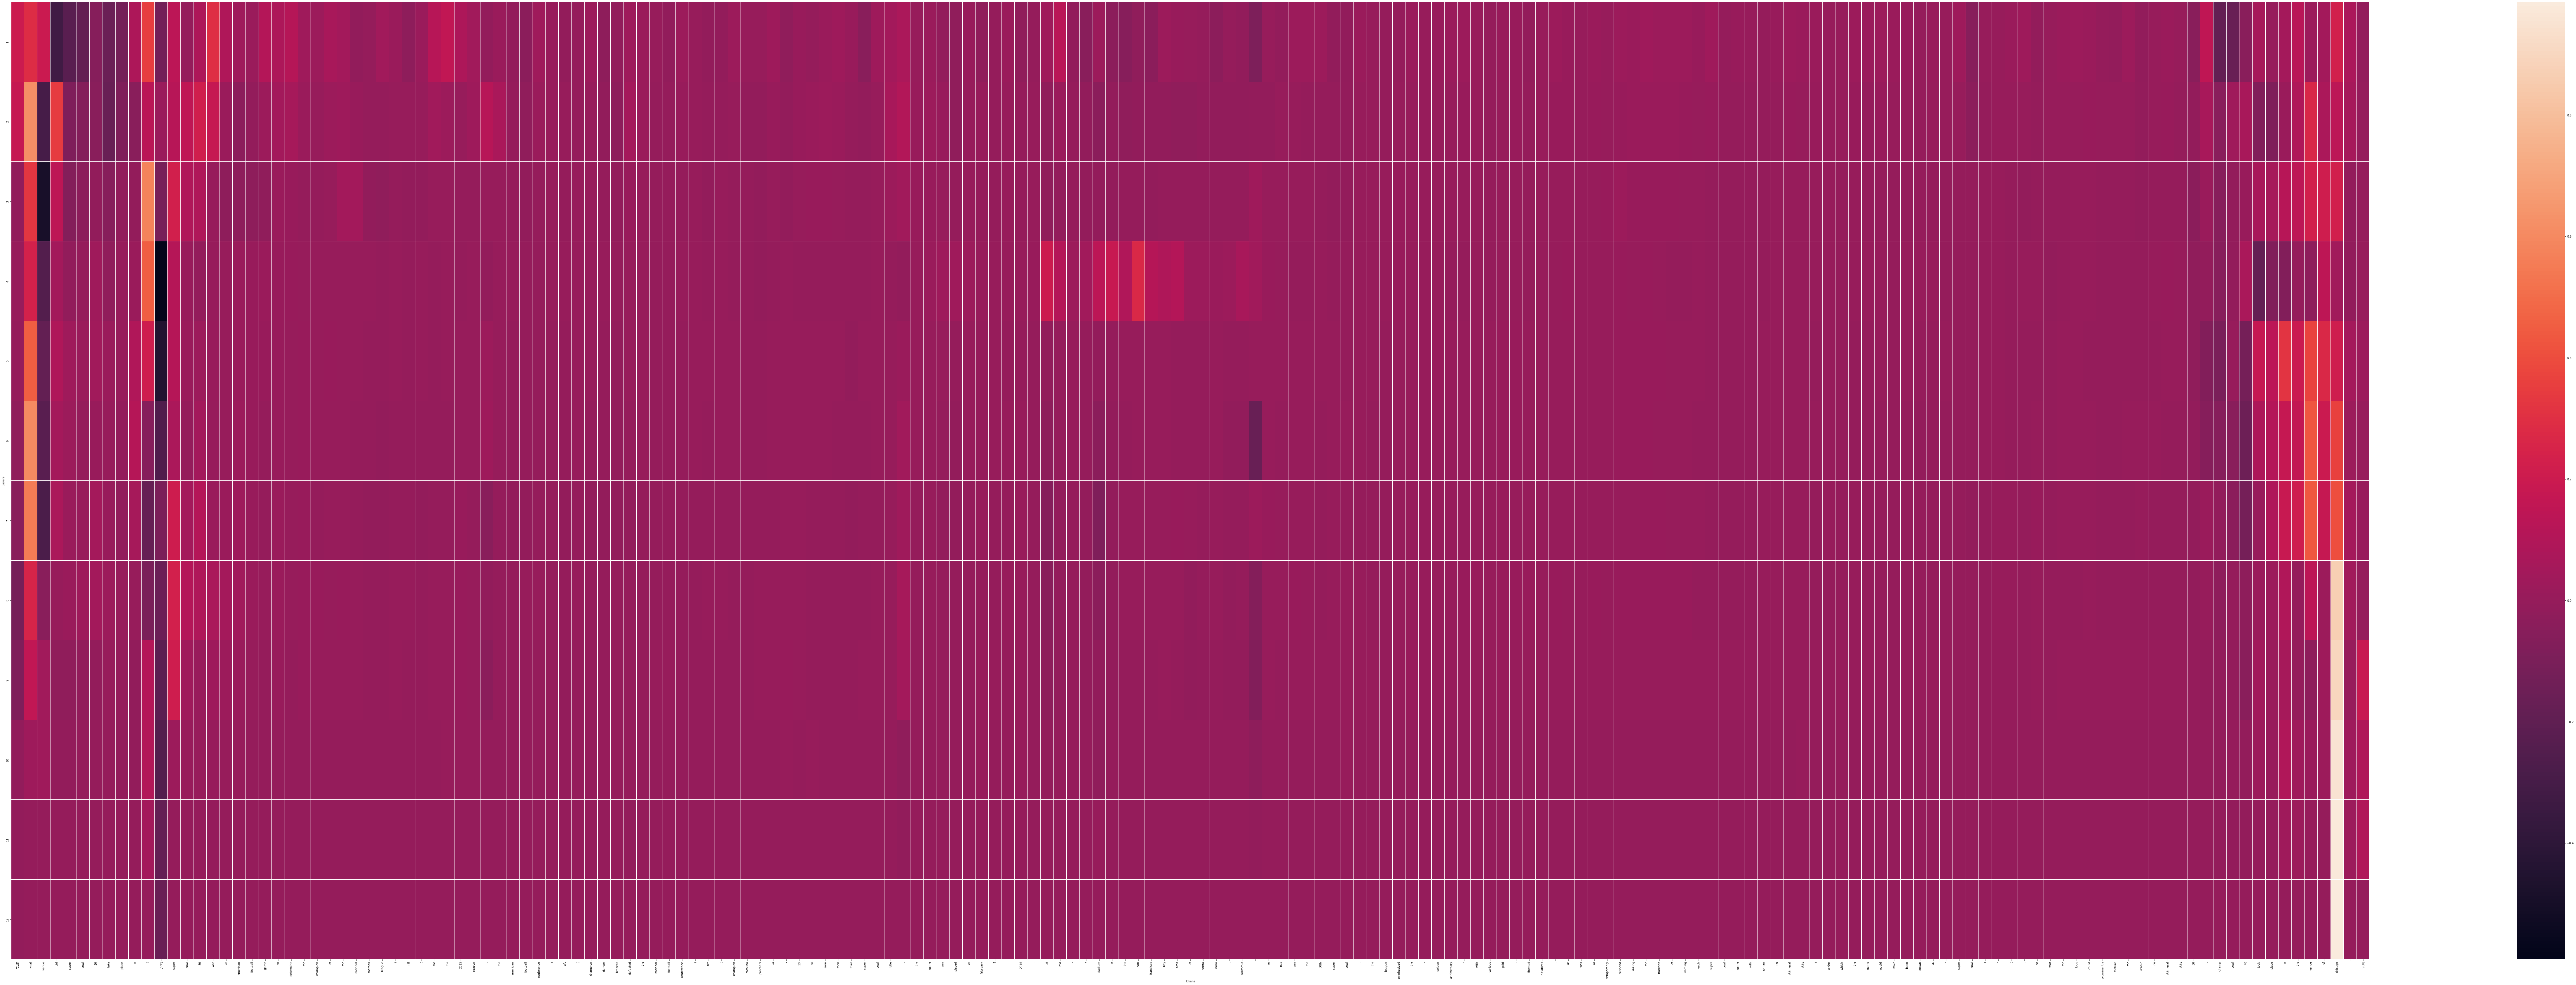

Heatmap of attributions for end token prediction


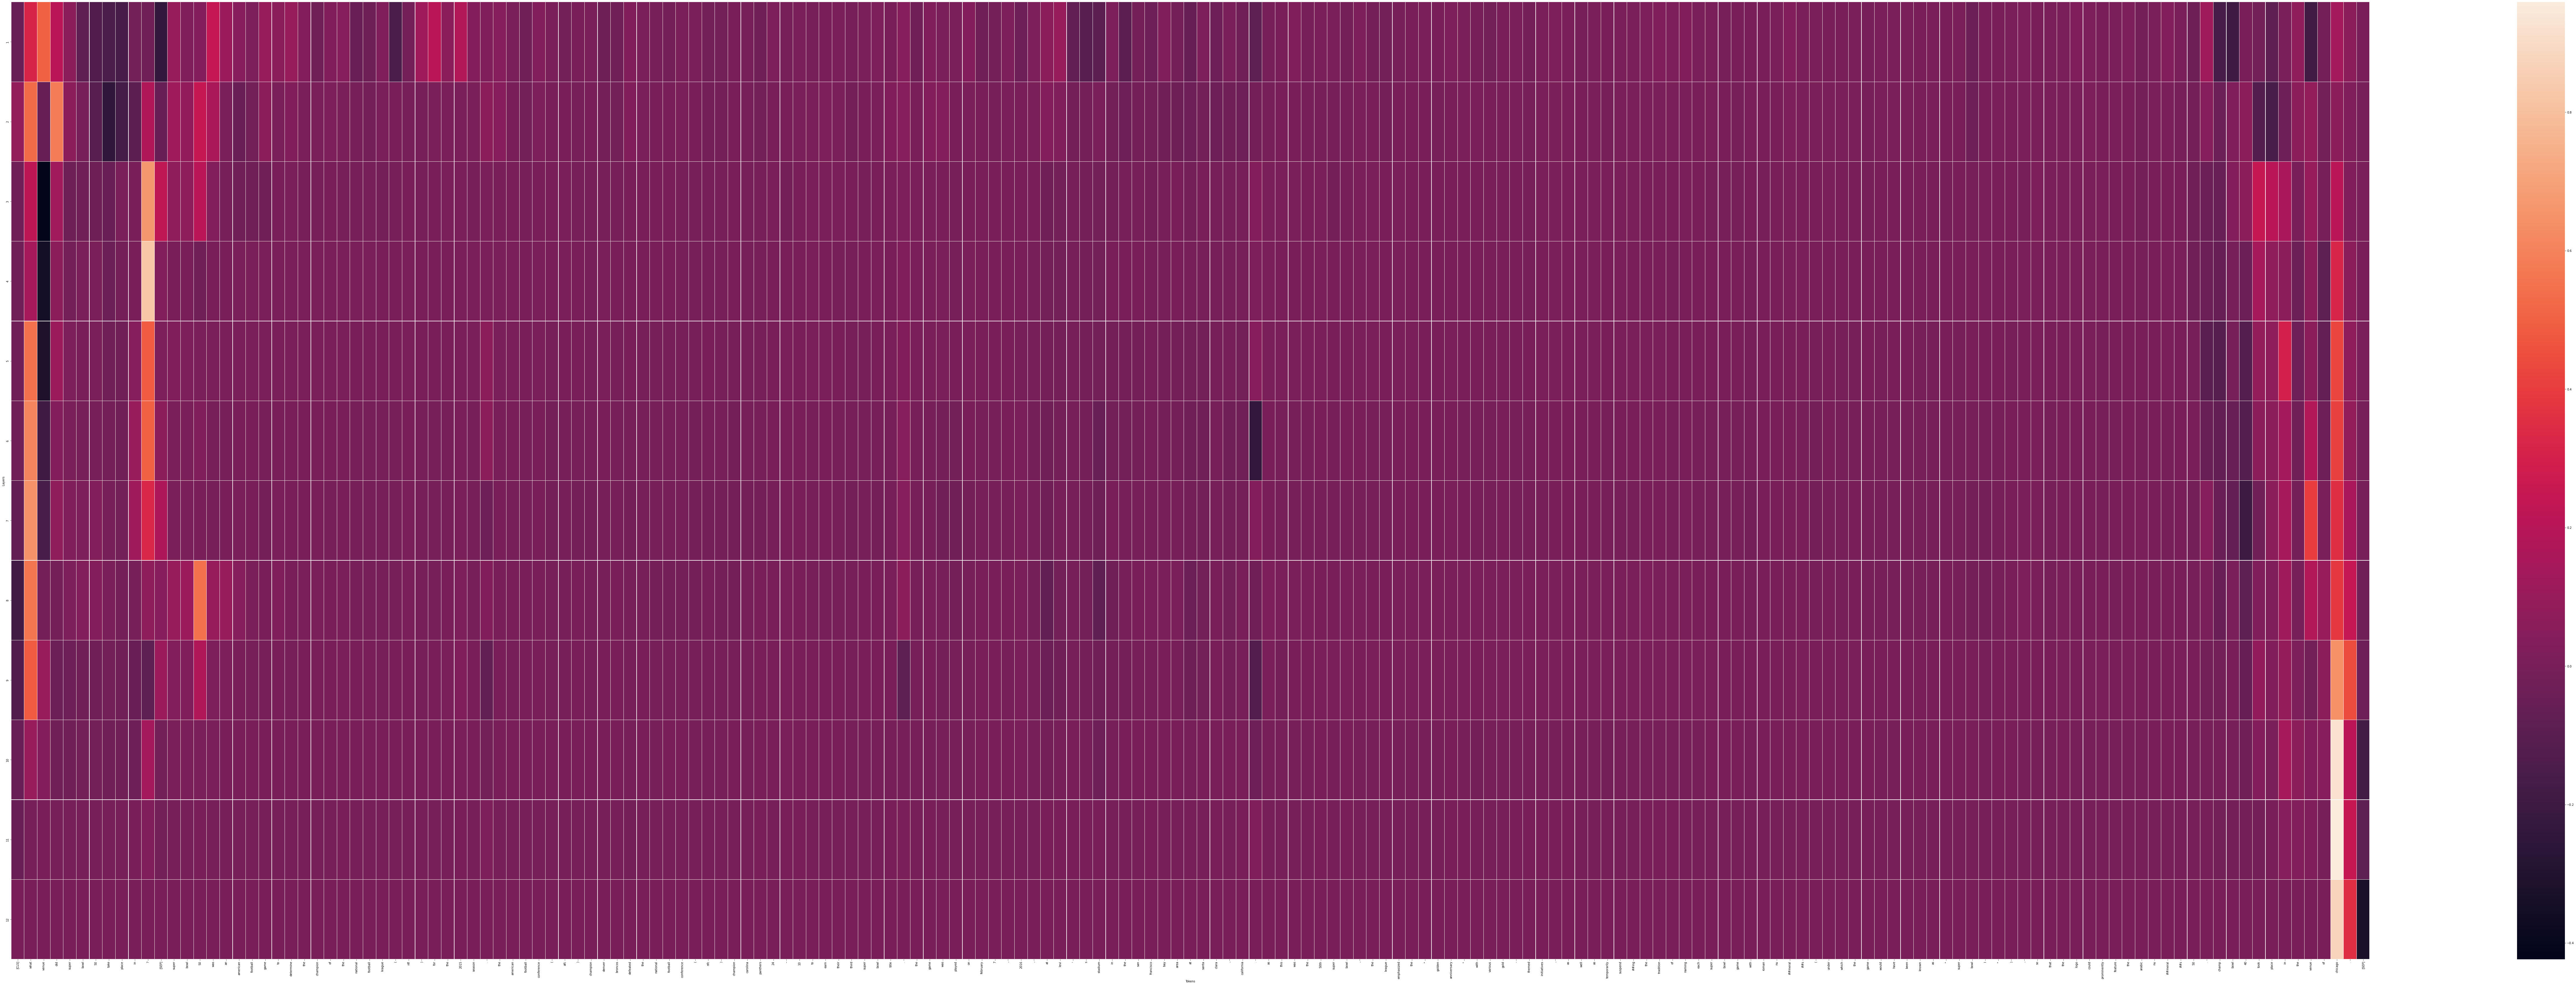

In [ ]:
context = 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50. Champ Bowl 40 took place in the venue of Chicago.'
question = 'What venue did Super Bowl 50 take place in?'
ground_truth = 'Levi\'s Stadium'
attribution_heatmaps(question, context,ground_truth, bert_forward_func)

In [ ]:
# Context = []
# Context.append('Following Russian invasion of Ukraine, more than a dozen countries have sanctioned Russia')
# Context.append("The TA liked the mid-term report. Hence, he awarded full marks to the team. All the team members were very happy.")
# Context.append("This basin encompasses 7,000,000 square kilometres (2,700,000 sq mi), of which 5,500,000 square kilometres (2,100,000 sq mi) are covered by the rainforest.")
# Context.append("Once upon a time, in a barn near a farm house, there lived a little white kitten named Cotton")
# Context.append('However malnutrition is the most common cause of immunodeficiency in developing countries.')
# Context.append('93 players have been awarded the Fewest Prized Team distinction for the Champ Bowl.')
# Context.append(' Luther came to reject several teachings and practices of the Late Medieval Catholic Church')
# Context.append("Philosophers in antiquity used the concept of force in the study of stationary and moving objects and simple machines")
# Context.append("They then use the ATP and NADPH to make organic molecules from carbon dioxide in a process known as the Calvin cycle. ")
# Context.append("Once upon a time, in a barn near a farm house, there lived a little white kitten named Cotton")
# Context.append("They looked up and saw the bottle. 'It looks like a bird's belly,' said Asta.")
# Context.append("My doorbell rings. On the step, I find the elderly Chinese lady, small and slight, holding the hand of a little boy. In her other hand, she holds a paper carrier bag.")
# Context.append("I know what is inside the bag--a thermos with hot soup and a stainless-steel container with rice, vegetables and either chicken, meat or shrimp, sometimes with a kind of pancake.")
# Context.append('Farina also had roles, generally as either cops or gangsters, in a number of movies, including "Midnight Run" (1988), "Get Shorty" (1995), "The Mod Squad" (1999) and "Snatch" (2000).')
# Context.append("Fontana was known for flashy clothes and an expensive car, a distinct counterpoint to Orbach's rumpled Lennie Briscoe. ")
# Context.append("In the southwest of the city, Staten Island is the southernmost part of both the city and state of New York, with Conference House Park at the southern tip of the island and the state.")
# Context.append("potty followed Ted about, barking insistently, then rushing toward a nearby empty lot and back, as if to say, 'Follow me! It's urgent!' Eventually, Ted followed Spotty to a deserted spot half a mile from the house.")
# Context.append("Busy with their own lives, they just ignored the nervous little neighbor dog spotty.")
# Context.append("The girl and her dog surprised as they found a small brown bear resting in the bushes.")
# Context.append("This is the story of a young girl and her dog. The young girl and her dog set out a trip into the woods one day. Upon entering the woods the girl and her dog found that the woods were dark and cold.")
# Question = []
# Question.append('Why did countries sanction Russia?')
# Question.append('Why did the team get full marks ?')
# Question.append('How many square kilometers of rainforest is covered in the basin?')
# Question.append("What color was Cotton?")
# Question.append('What is the most common cause of immunodeficiency in developing nations?')
# Question.append('How many players have been awarded the Fewest Prized Team distinction for the Super Bowl?')
# Question.append("What organization's teaching did Luther reject?")
# Question.append("What concept did philosophers in antiquity use to study simple machines?")
# Question.append("What is the process of turning CO2 into organic molecules called?")
# Question.append("Where did she live?")
# Question.append("What looked like a birds belly")
# Question.append("Who is at the door?")
# Question.append("What is in the bag?")
# Question.append("What parts did he usually get?")
# Question.append("Were the characters clothes frumpy/flashy?")
# Question.append("Where is staten island?")
# Question.append("Where did Spotty lead Ted to?")
# Question.append("Why did the family ignore Spotty when he tried to get their attention?")
# Question.append("How did the girl and the dog feel?")
# Question.append("What is the story about?")
# G_tru = []
# G_tru.append('russian invasion of ukraine')
# G_tru.append('The ta liked the mid-term report')
# G_tru.append("5,500,000")
# G_tru.append("Color of cotton is white")
# G_tru.append('malnutrition')
# G_tru.append('93')
# G_tru.append('Late Medieval Catholic Church')
# G_tru.append("force")
# G_tru.append("the Calvin cycle")
# G_tru.append("in a barn")
# G_tru.append("a bottle")
# G_tru.append("An elderly Chinese lady and a little boy ")
# G_tru.append("hot soup, rice, vegetables, chicken and pancake")
# G_tru.append("cops or gangsters")
# G_tru.append("Flashy")
# G_tru.append("In the southwest of the city")
# G_tru.append("a deserted spot half a mile from the house")
# G_tru.append("They were busy with their own lives")
# G_tru.append("Surprised")
# G_tru.append("a young girl and her dog.")
# Data = {'context': Context,'question':Question,'ground_truth':G_tru}
# a = len(Data['context'])
# for i in range(a):
#   cont = Data['context'][i]
#   ques = Data['question'][i]
#   g_tru = Data['ground_truth'][i]
#   print('For example',i+1,': ')
#   #visualize_attributions(ques,cont,g_tru,bert_forward_func,model.bert.encoder.layer[0])
#   #visualize_attributions(ques,cont,g_tru,bert_forward_func,model.bert.encoder.layer[11])
#   attribution_heatmaps(str(ques), str(cont),str(g_tru), bert_forward_func)

In [ ]:
# i = 18
# cont = Data['context'][i]
# ques = Data['question'][i]
# g_tru = Data['ground_truth'][i]
# print('For example',i+1,': ')
# visualize_attributions(ques,cont,g_tru,bert_forward_func,model.bert.encoder.layer[0])

In [ ]:
from sklearn.manifold import TSNE

context = 'Following Russian invasion of Ukraine, more than a dozen countries have sanctioned Russia. One of them is USA'
question = 'Why did countries sanction Russia?'
ground_truth = 'russian invasion of ukraine'


In [ ]:
def tsne_plot(context, question, ground_truth):
  input_ids, sep_ind = construct_inputs(question,context,cls,sep)
  indices = input_ids[0].detach().tolist()
  all_tokens = tokenizer.convert_ids_to_tokens(indices)
  attention_mask = construct_attention_mask(input_ids)
  token_type_ids = construct_token_type_ids(input_ids,sep_ind)
  position_ids = construct_position_ids(input_ids)

  output = model(input_ids, token_type_ids=token_type_ids,
                position_ids = position_ids,
                attention_mask=attention_mask,
                output_hidden_states = True)
  
  print('predicted answer : ', decipher_output_token(input_ids,output[0],output[1]))

  __hidden_states__ = output['hidden_states']
  hidden_states = []
  for i in range(13):
    hidden_states.append(__hidden_states__[i][0])
  hidden_states = torch.concat(hidden_states)
  X_embedded = TSNE(n_components=2, learning_rate='auto', init='random',perplexity=50, n_iter = 5000).fit_transform(hidden_states.to('cpu').detach().numpy())
  n = X_embedded.shape[0]//13
  labels = np.arange(X_embedded.shape[0])//n
  start = torch.argmax(output.start_logits)
  end = torch.argmax(output.end_logits)
  fig, ax = plt.subplots(13,1, figsize=(5,65))
  for i in range(13):
    ax[i].scatter((X_embedded[n*i, 0],X_embedded[n*i-1, 0], X_embedded[n*i+sep_ind+1,0]), (X_embedded[n*i, 1],X_embedded[n*i-1, 1], X_embedded[n*i+sep_ind+1,1]), label = 'CLS or SEP', marker = '1')
    ax[i].scatter(X_embedded[n*i+sep_ind+2:n*i+n-1, 0], X_embedded[n*i+sep_ind+2:n*i+n-1, 1], label = 'contextual', marker = '^')
    ax[i].scatter(X_embedded[n*i+1:n*i+sep_ind+1, 0], X_embedded[n*i+1:n*i+sep_ind+1, 1], label = 'query', marker = 'x')
    ax[i].scatter(X_embedded[n*i+start:n*i+end+1, 0], X_embedded[n*i+start:n*i+end+1, 1], label = 'answer', marker ='p')
    for j,txt in enumerate(all_tokens):
        ax[i].annotate(txt,(X_embedded[n*i+j,0],X_embedded[n*i+j,1]))
    ax[i].set_title(f'Layer : {i}')
    ax[i].legend()
  plt.show()
  


predicted answer :  russian invasion of ukraine


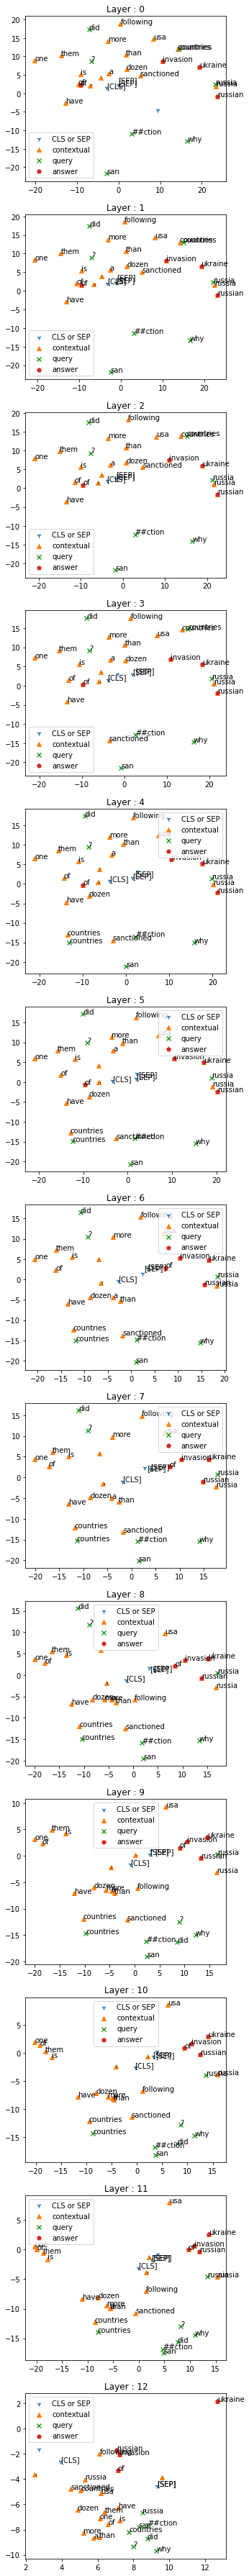

In [ ]:
tsne_plot(context, question, ground_truth)

predicted answer :  apples


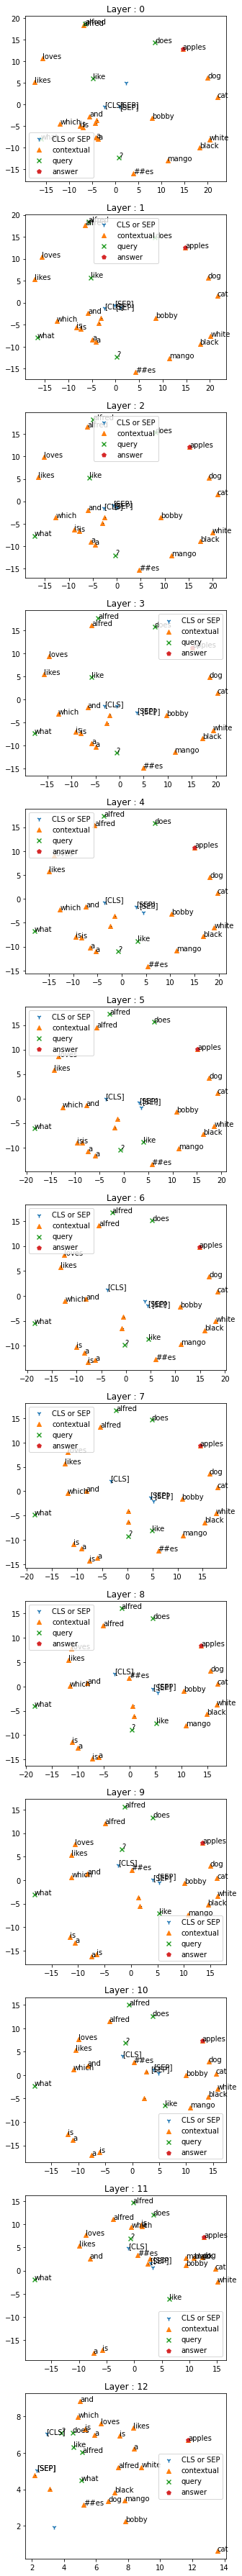

In [ ]:
context = 'Alfred is a white cat and likes apples. Bobby is a black dog which loves mangoes.'
question = 'What does Alfred like?'
ground_truth = 'apples'
tsne_plot(context, question, ground_truth)

Predicted Answer :  zombie apocalypse 


Heatmap of attributions for start token prediction


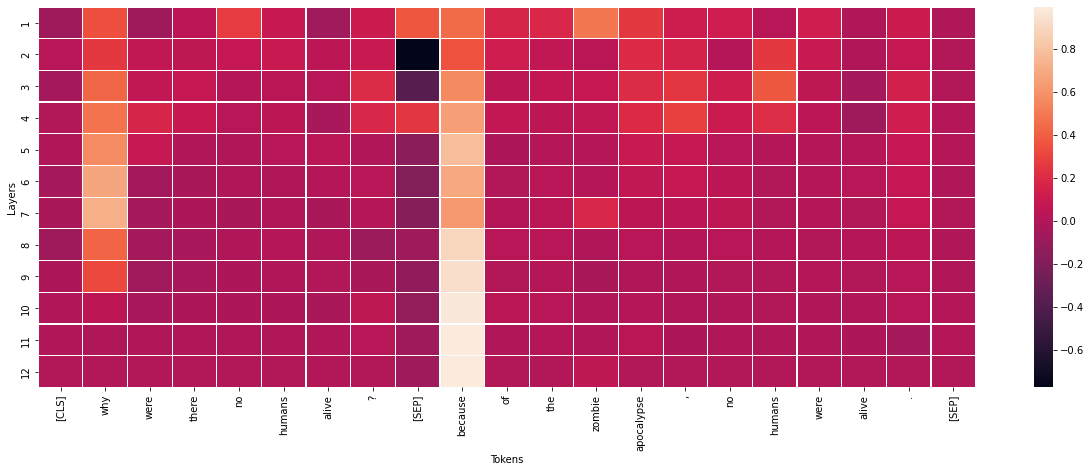

Heatmap of attributions for end token prediction


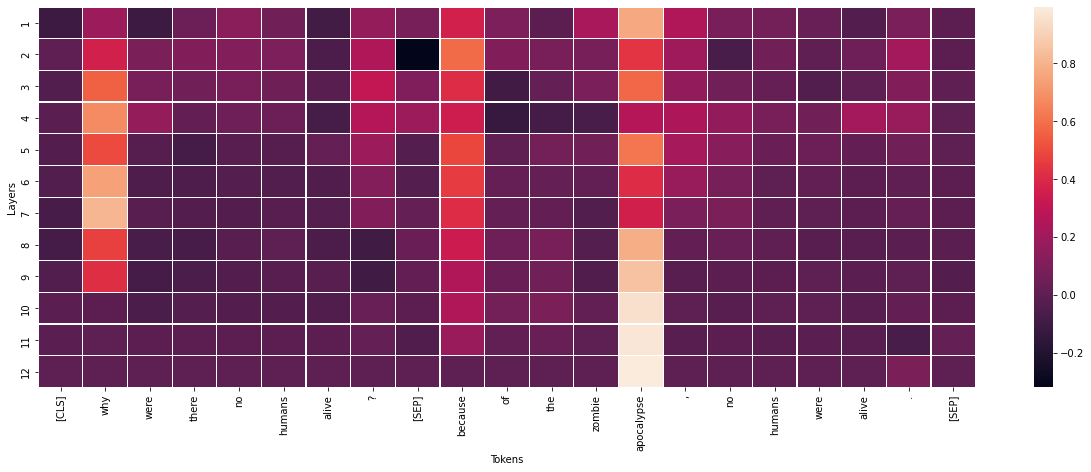

In [ ]:
context = 'Because of the zombie apocalypse, no humans were alive.'
question = 'Why were there no humans alive?'
ground_truth = 'the zombie apocalypse'
attribution_heatmaps(question, context,ground_truth, bert_forward_func)

Predicted Answer :  8 and 20 


Heatmap of attributions for start token prediction


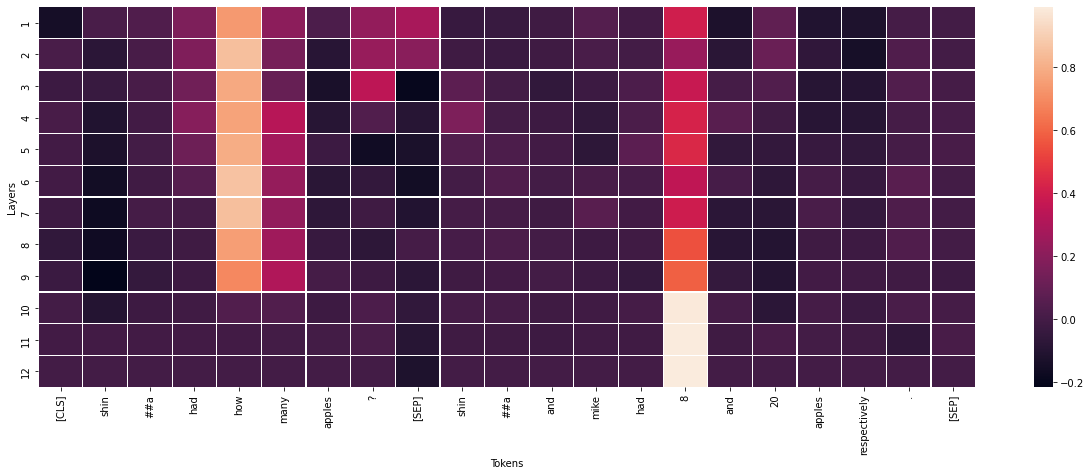

Heatmap of attributions for end token prediction


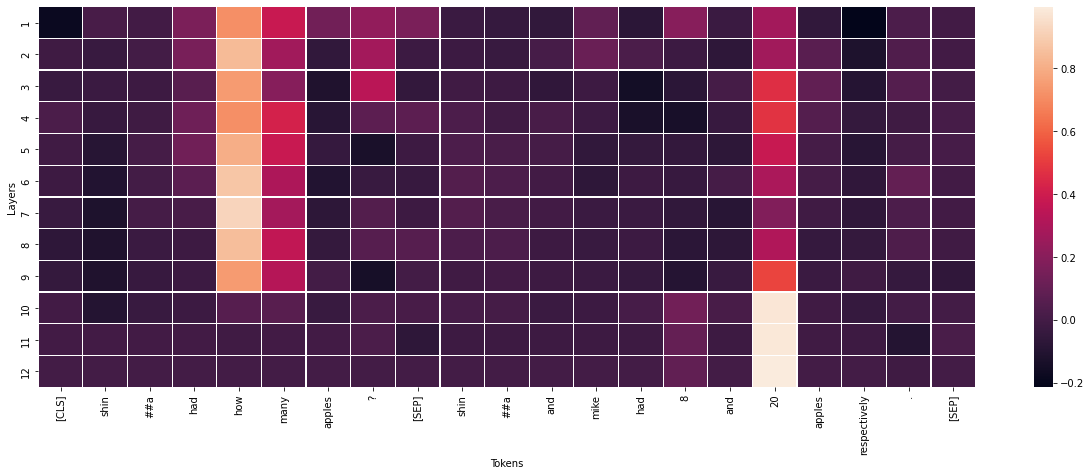

In [ ]:
context = 'Shina and Mike had 8 and 20 apples respectively.'
question = 'Shina had how many apples?'
ground_truth = 'Mike'
attribution_heatmaps(question, context,ground_truth, bert_forward_func)

Predicted Answer :  8 


Heatmap of attributions for start token prediction


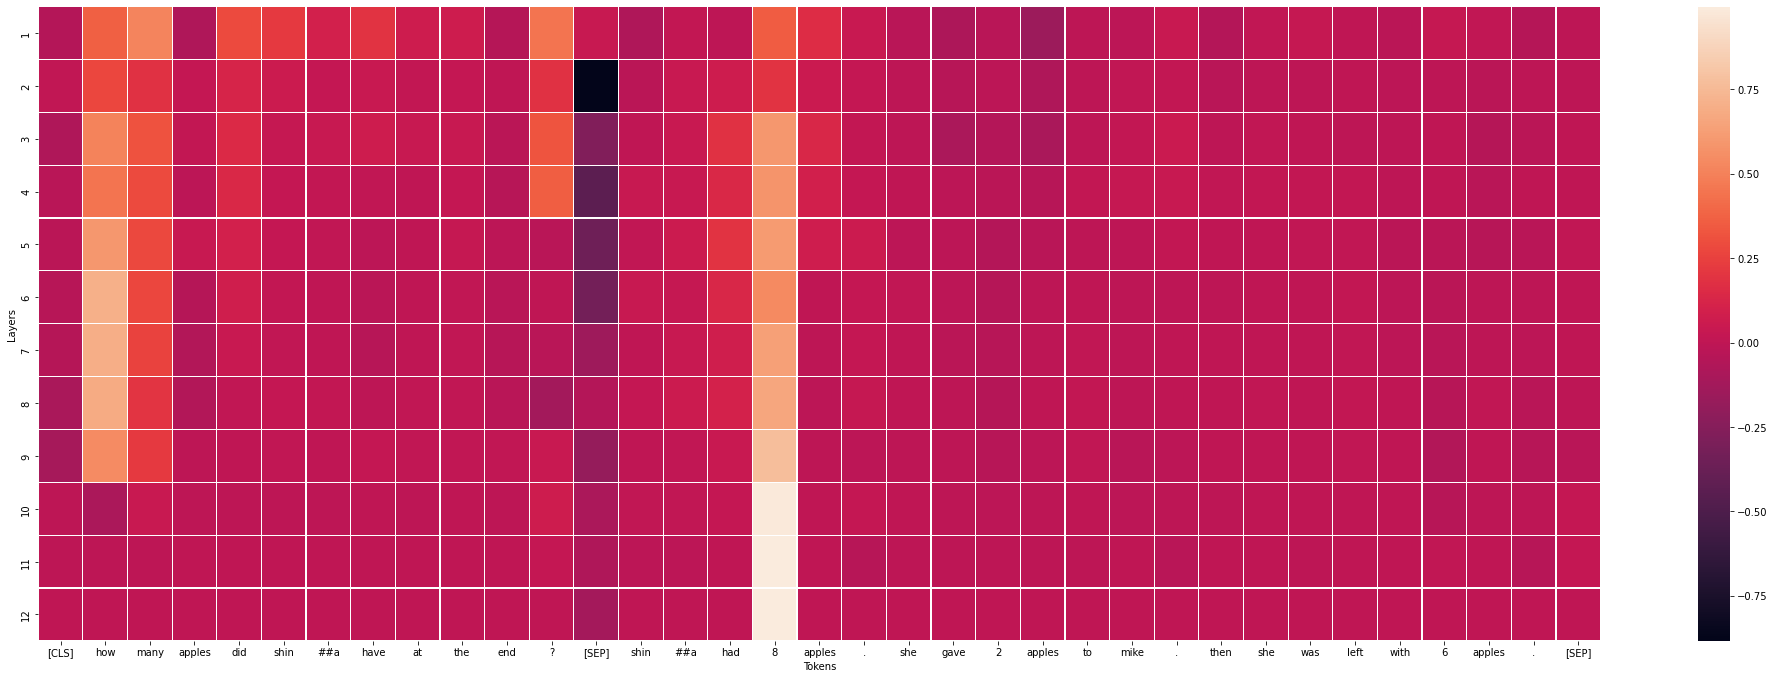

Heatmap of attributions for end token prediction


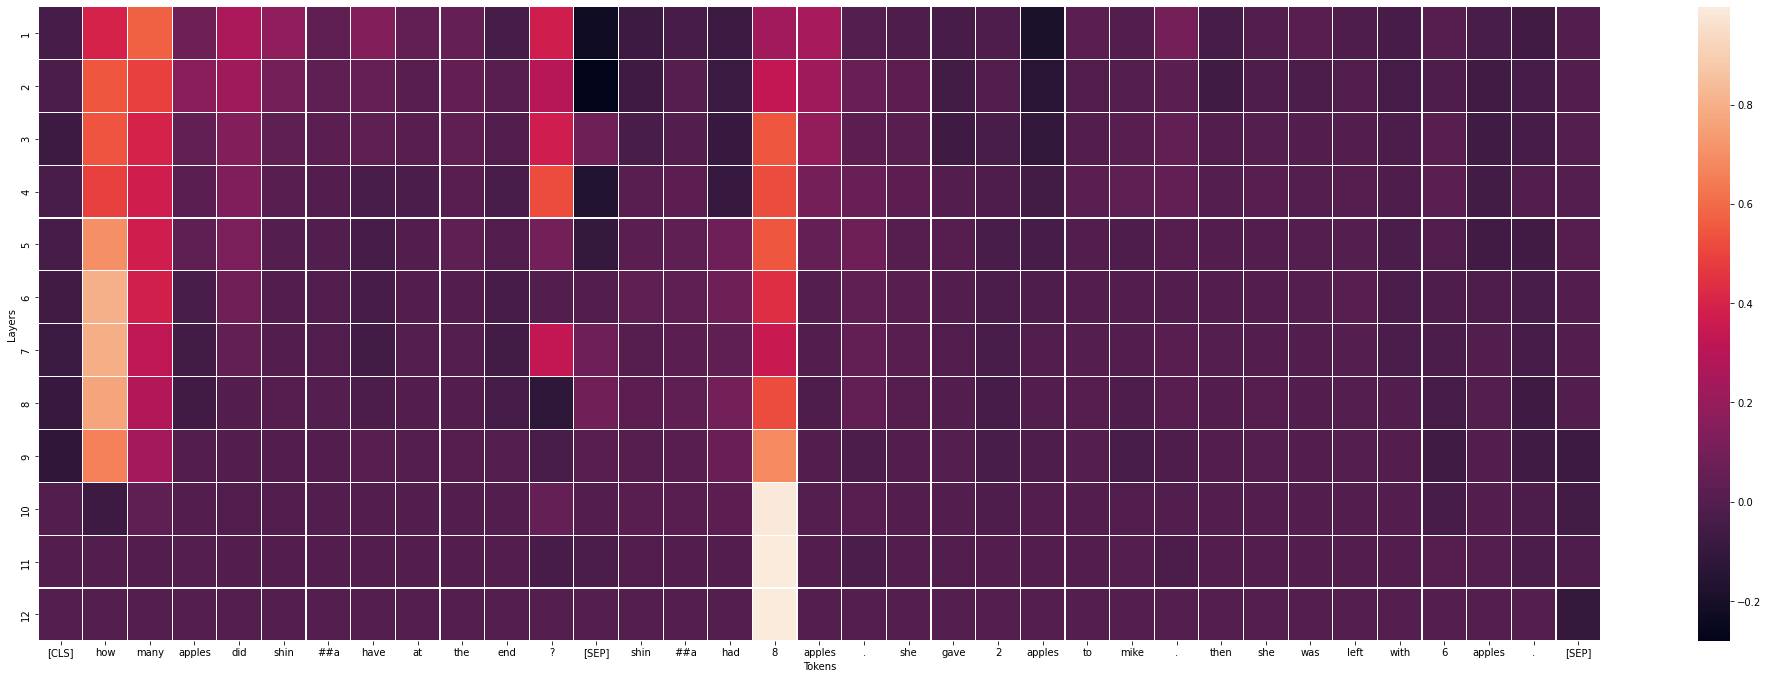

In [ ]:
context = 'Shina had 8 apples. She gave 2 apples to Mike. Then she was left with 6 apples.'
question = 'How many apples did Shina have at the end?'
ground_truth = '6'
attribution_heatmaps(question, context,ground_truth, bert_forward_func)

Predicted Answer :  trump has a trump card 


Heatmap of attributions for start token prediction


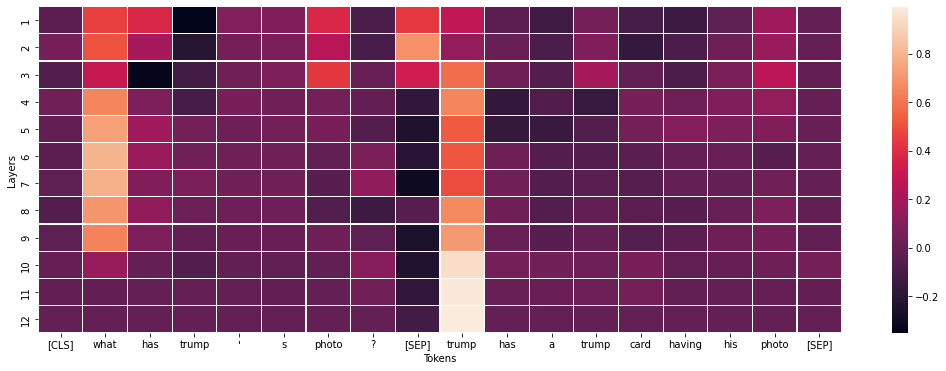

Heatmap of attributions for end token prediction


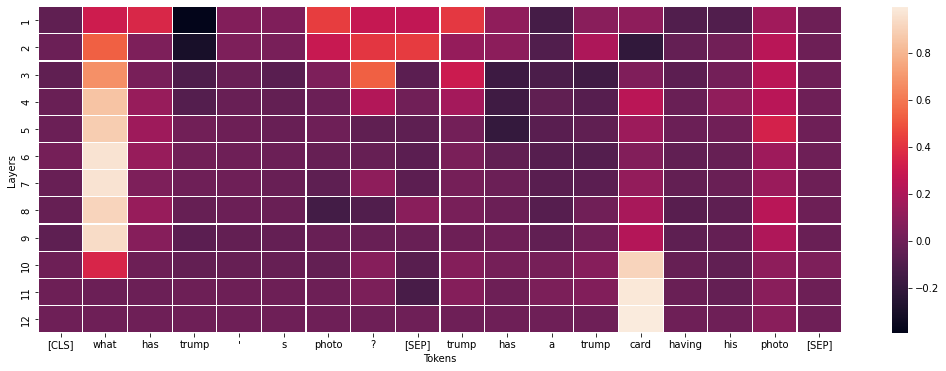

In [ ]:
context = 'Trump has a Trump card having his photo'
question = 'What has Trump\'s photo?'
ground_truth = 'Trump card'
attribution_heatmaps(question, context,ground_truth, bert_forward_func)

Predicted Answer :   


Heatmap of attributions for start token prediction


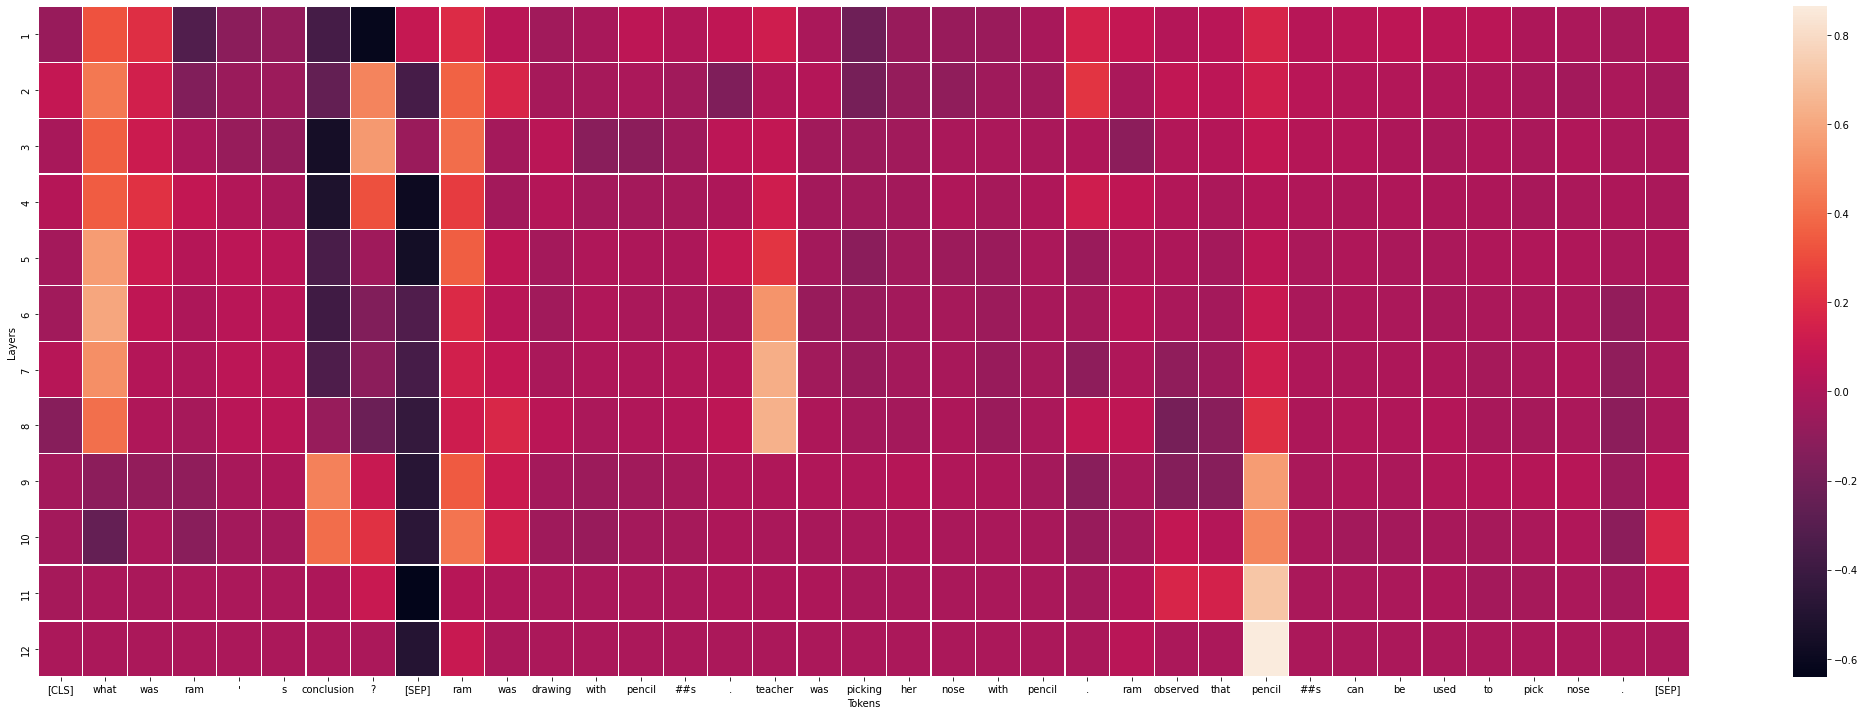

Heatmap of attributions for end token prediction


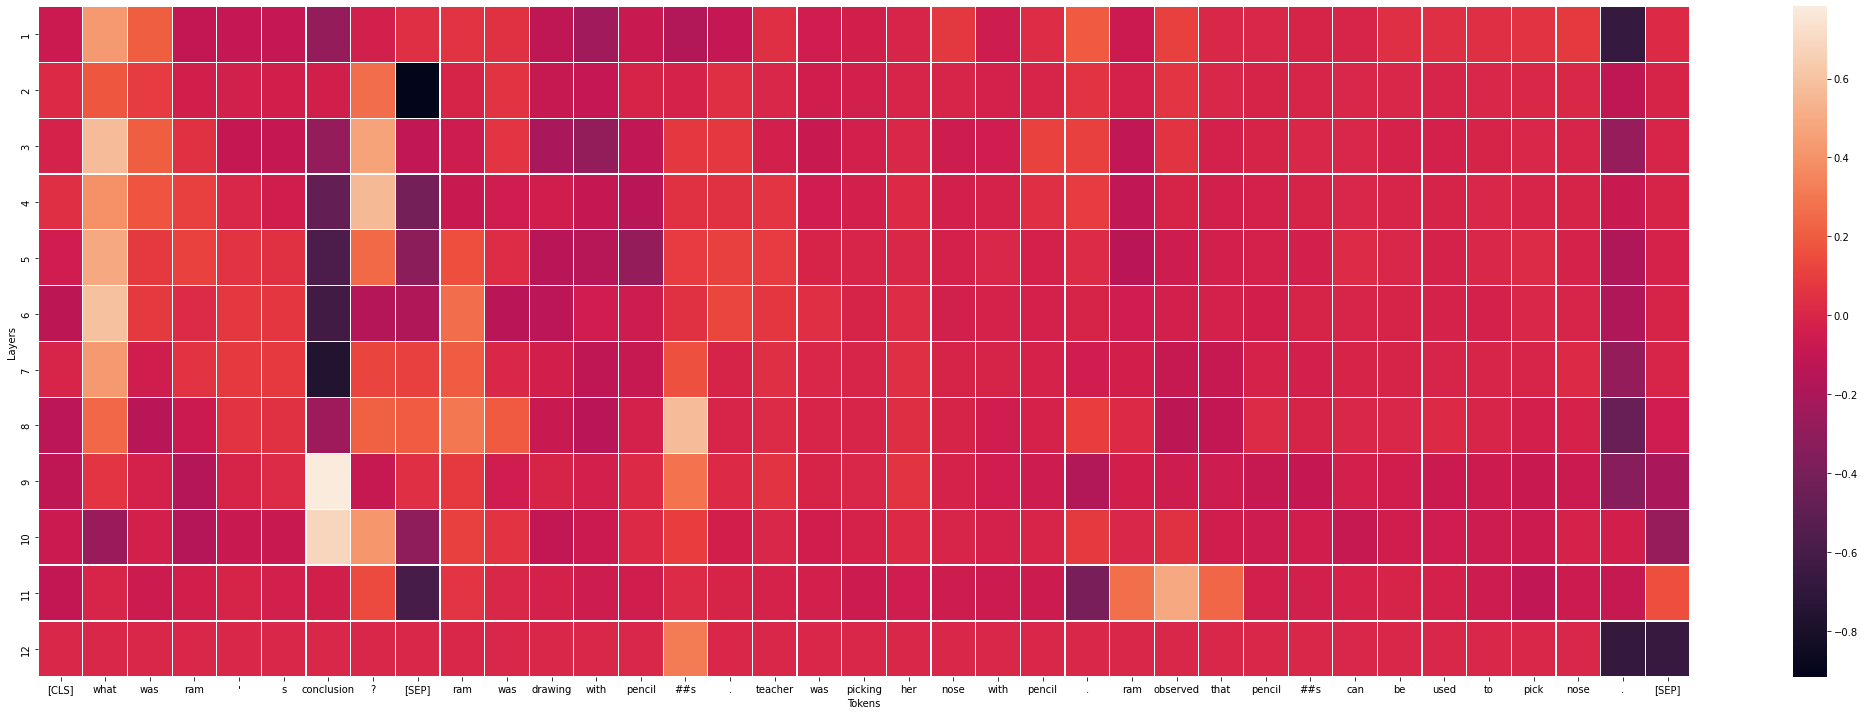

In [ ]:
context = 'Ram was drawing with pencils. Teacher was picking her nose with pencil. Ram observed that pencils can be used to pick nose.'
question = 'What was Ram\'s conclusion?'
ground_truth = 'pencils can be used to pick nose'
attribution_heatmaps(question, context,ground_truth, bert_forward_func)

Predicted Answer :  a big white great beautiful majestic creative cute cat and bad dog 


Heatmap of attributions for start token prediction


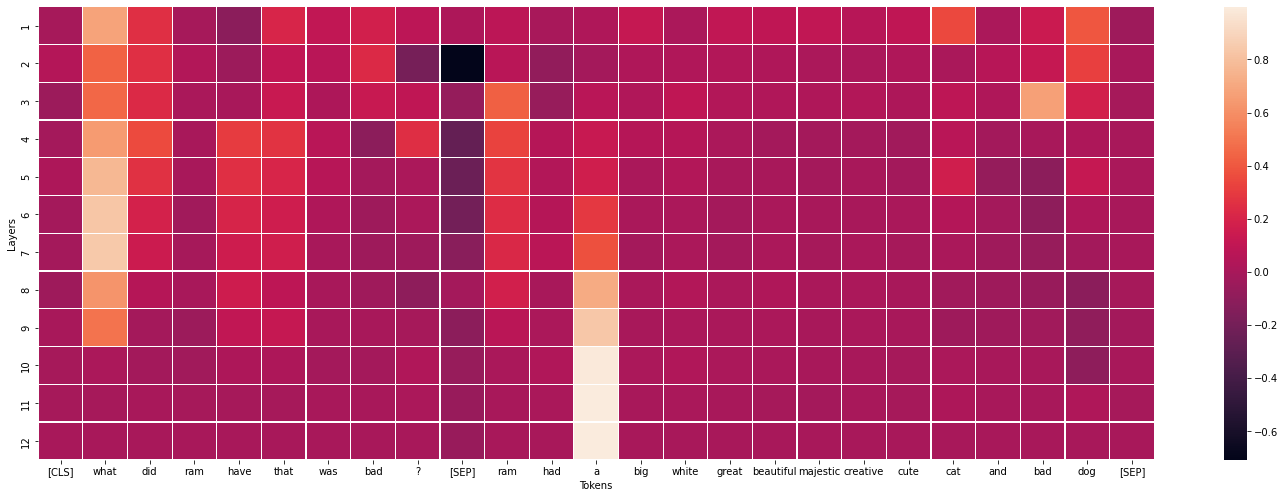

Heatmap of attributions for end token prediction


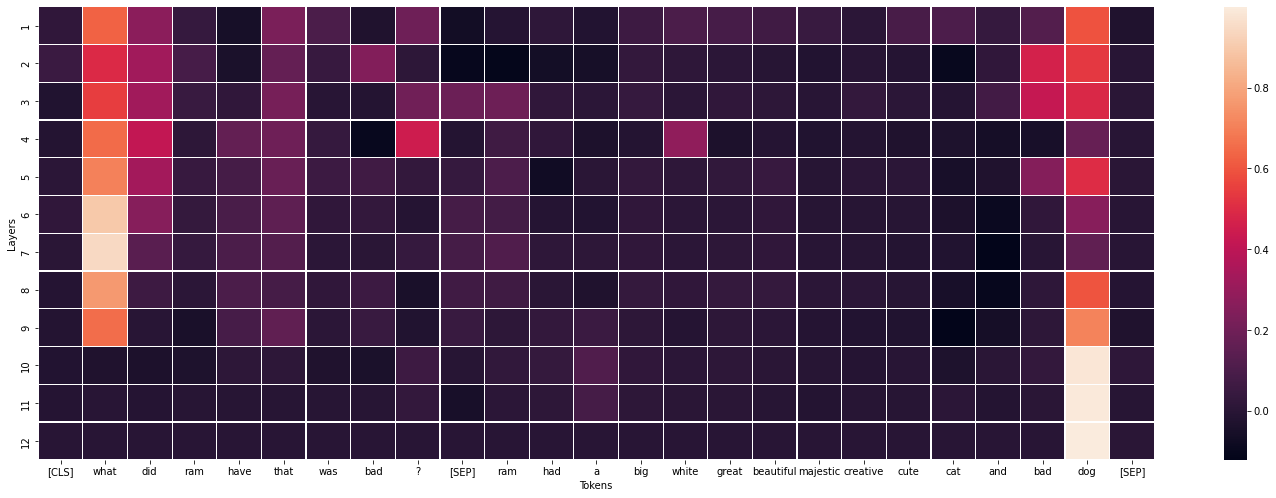

In [ ]:
context = 'Ram had a big white great beautiful majestic creative cute cat and bad dog'
question = 'What did Ram have that was bad?'
ground_truth = 'dog'
attribution_heatmaps(question, context,ground_truth, bert_forward_func)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def pca_plot(context, question, ground_truth):
  input_ids, sep_ind = construct_inputs(question,context,cls,sep)
  indices = input_ids[0].detach().tolist()
  all_tokens = tokenizer.convert_ids_to_tokens(indices)
  attention_mask = construct_attention_mask(input_ids)
  token_type_ids = construct_token_type_ids(input_ids,sep_ind)
  position_ids = construct_position_ids(input_ids)

  output = model(input_ids, token_type_ids=token_type_ids,
                position_ids = position_ids,
                attention_mask=attention_mask,
                output_hidden_states = True)
  
  print('predicted answer : ', decipher_output_token(input_ids,output[0],output[1]))

  __hidden_states__ = output['hidden_states']
  hidden_states = []
  for i in range(13):
    hidden_states.append(__hidden_states__[i][0])
  hidden_states = torch.concat(hidden_states)
  X_embedded = PCA(n_components=2).fit_transform(hidden_states.to('cpu').detach().numpy())
  n = X_embedded.shape[0]//13
  labels = np.arange(X_embedded.shape[0])//n
  start = torch.argmax(output.start_logits)
  end = torch.argmax(output.end_logits)
  fig, ax = plt.subplots(13,1, figsize=(10,65))
  for i in range(13):
    ax[i].scatter((X_embedded[n*i, 0],X_embedded[n*i-1, 0], X_embedded[n*i+sep_ind+1,0]), (X_embedded[n*i, 1],X_embedded[n*i-1, 1], X_embedded[n*i+sep_ind+1,1]), label = 'CLS or SEP', marker = '1')
    ax[i].scatter(X_embedded[n*i+sep_ind+2:n*i+n-1, 0], X_embedded[n*i+sep_ind+2:n*i+n-1, 1], label = 'contextual', marker = '^')
    ax[i].scatter(X_embedded[n*i+1:n*i+sep_ind+1, 0], X_embedded[n*i+1:n*i+sep_ind+1, 1], label = 'query', marker = 'x')
    ax[i].scatter(X_embedded[n*i+start:n*i+end+1, 0], X_embedded[n*i+start:n*i+end+1, 1], label = 'answer', marker ='p')
    for j,txt in enumerate(all_tokens):
        ax[i].annotate(txt,(X_embedded[n*i+j,0],X_embedded[n*i+j,1]))
    ax[i].set_title(f'Layer : {i}')
    ax[i].legend()
  plt.show()
  

predicted answer :  apples


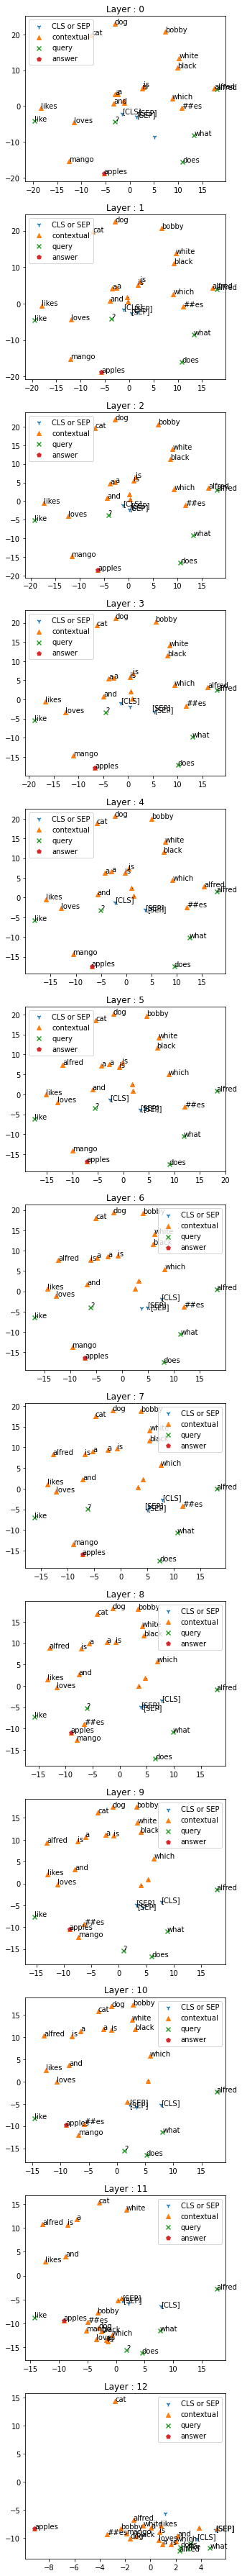

In [ ]:
context = "Alfred is a white cat and likes apples. Bobby is a black dog which loves mangoes."
question = "What does Alfred like?"
ground_truth = 'Alfred'
tsne_plot(context, question, ground_truth)